# Experiment: What is the best split criteria for RF Regression?

Vivek Gopalakrishnan | October 28, 2019


## My Random Forest setup

Split criteria being tested:

1. Mean Absolute Error (MAE)
2. Mean Squared Error (MSE)
3. Axis projections
4. Random projections


## My sampling model for synthetic data

Input data is sampled from a $d$-dimensional multivariate normal (MVN) and the output data is a random rotation of the input data.

Specifically,
$$
X_i \sim \text{MVN}\left(\mu, I_d\right) \,, y_i = AX_i \\
\mathcal{D}_n = \left\{(X_i, y_i)\right\} \text{ for } i=1,\dots,n
$$
where $A$ is a random rotation matrix sampled according to [the Haar distribution](http://scipy.github.io/devdocs/generated/scipy.stats.ortho_group.html) and $d$ is the number of simulated features.


## What simulations are run in this notebook?

Simulation parameters are `(n_samples, n_dim)`. I run the following simulations:

1. Increase `n_samples`, fix `n_dim=2`
2. Increase `n_dim`, fix `n_samples=50`

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import kruskal

from simulation import generate_linear_data, generate_nonlinear_data, measure_mse

In [2]:
%load_ext autoreload
%autoreload 2

## Demo of simulation functions

The module `simulation` provides two functions:
1. `generate_linear_data`: sample data according to the model above
2. `measure_mse`: for a given set of sample data, measure the MSE for all split criteria

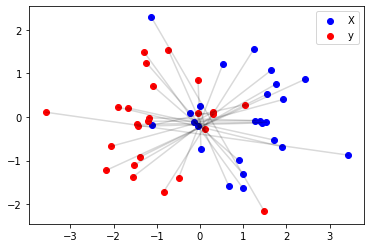

In [3]:
# Test data generation function
X, y = generate_linear_data(n_samples=25, n_dim=2, scale=0.1)

# Plot synthetic data
plt.scatter(X[:, 0], X[:, 1], c="blue", label="X")
plt.scatter(y[:, 0], y[:, 1], c="red", label="y")

# Plot lines between matched pairs of points
for xi, yi in zip(X, y):
    plt.plot(
        [xi[0], yi[0]], 
        [xi[1], yi[1]], 
        c="black", 
        alpha = 0.15
    )

plt.legend()
plt.show()

In [4]:
# Test MSE measuring function
measure_mse(X, y)

[0.6262621751691868,
 0.6523233135660176,
 0.7221427744460375,
 0.7379314881549393]

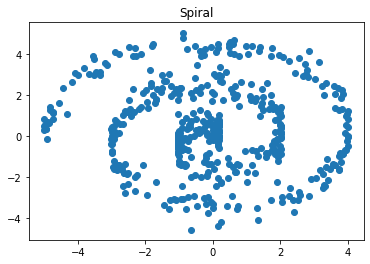

In [5]:
# Test nonlinear data generation function
X, y = generate_nonlinear_data("spiral_sim", n_samples=500, n_dim=1)

# Plot synthetic data
plt.scatter(X, y)
plt.title("Spiral")
plt.show()

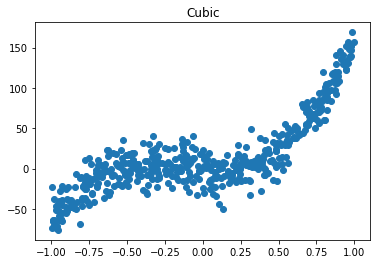

In [6]:
# Test nonlinear data generation function
X, y = generate_nonlinear_data("cub_sim", n_samples=500, n_dim=1)

# Plot synthetic data
plt.scatter(X, y)
plt.title("Cubic")
plt.show()

## Simulation

Run simulation with `python simulation.py`. Analyzed results are below.

### Simulation 1: Increasing dimensionality

- `n_samples = 75`
- `n_dim = [2, 3, 4, ..., 40]`

In [7]:
df = pd.read_csv("results/simulation_1.csv", index_col="Unnamed: 0")
df.head()

,n_samples,n_dim,split,mse
0,75,2,mae,1.109144
1,75,2,mae,1.114019
2,75,2,mae,0.584492
3,75,2,mae,0.754515
4,75,2,mae,0.660824


[Text(0, 0.5, 'mse'), Text(0.5, 0, 'n_dim')]

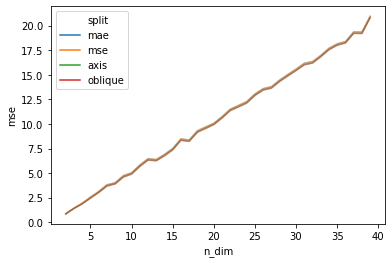

In [8]:
f = sns.lineplot(x="n_dim", y="mse", hue="split", data=df, ci=None, alpha=0.5)
f.set(xlabel="n_dim", ylabel="mse")

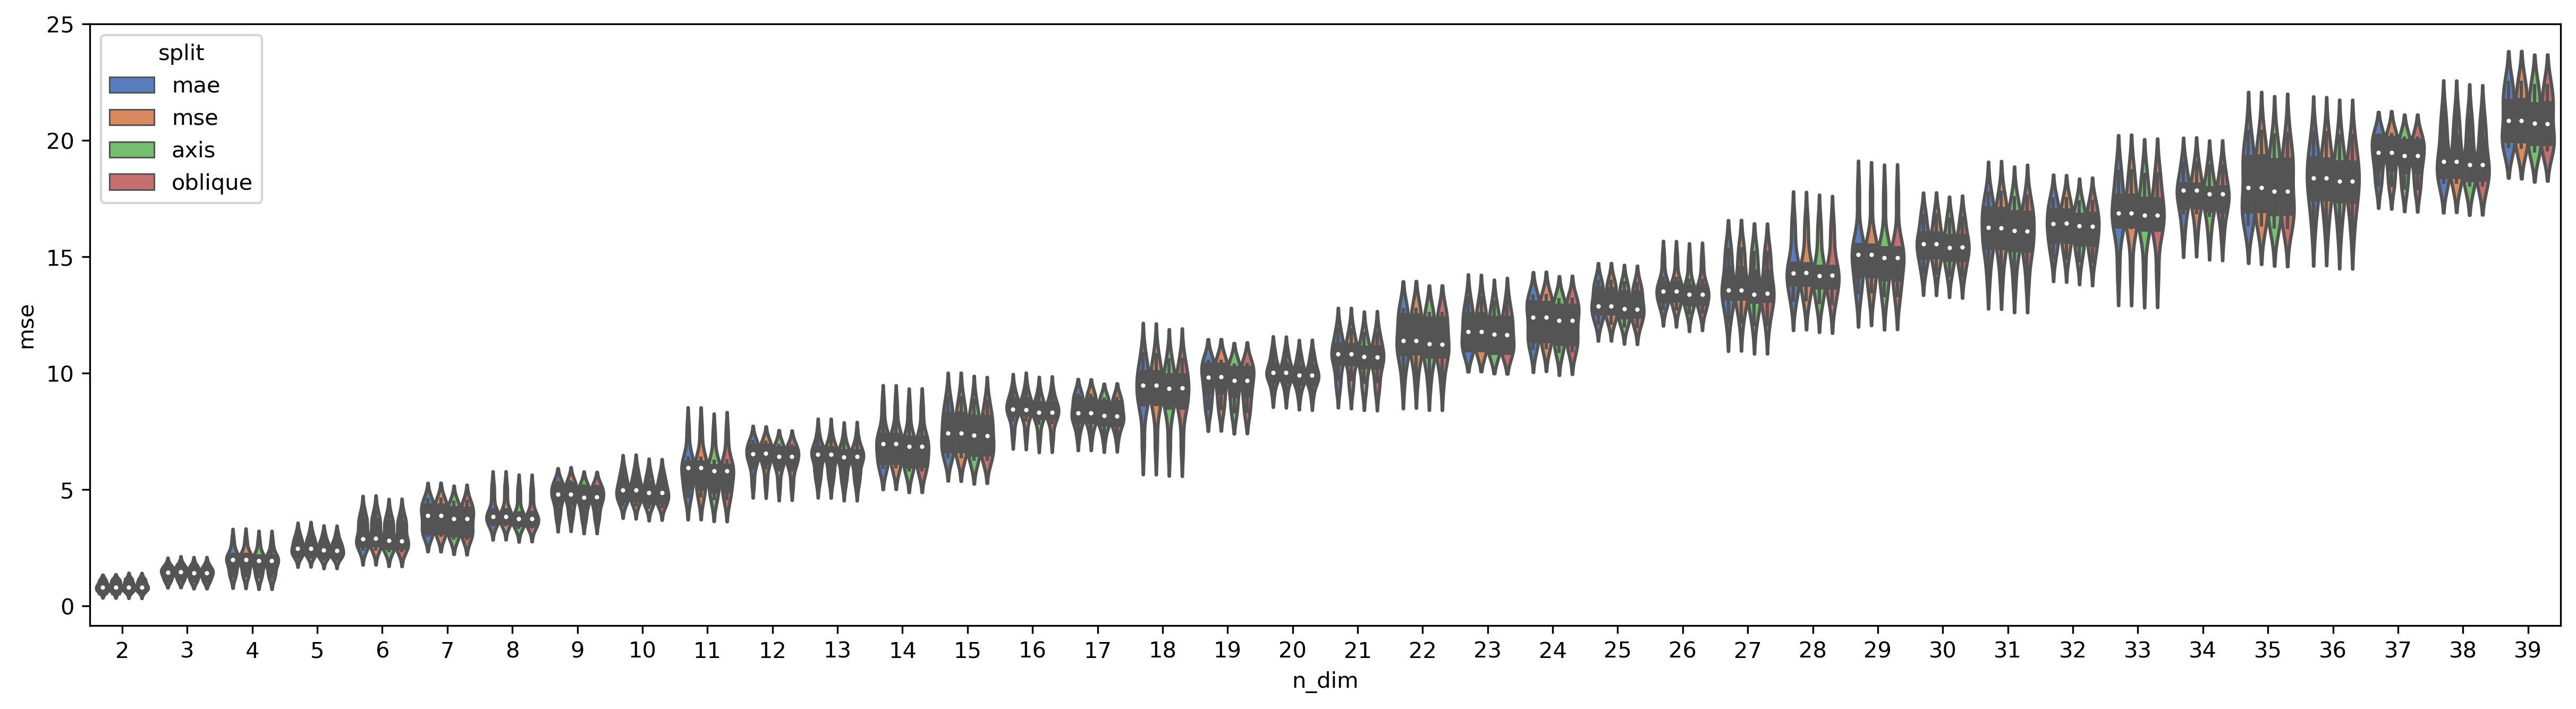

In [9]:
fig, ax = plt.subplots(dpi=300, figsize=(20, 5))
g = sns.violinplot(x="n_dim", y="mse", hue="split", data=df, palette="muted", ax=ax)

In [10]:
# Test if splitters perform significantly differently with Kruskal-Wallis
for n_dim in df.n_dim.unique():

    test = []
    for splitter in ["mae", "mse", "axis", "oblique"]:

        mse = df.query(f"n_dim=={n_dim} and split=='{splitter}'").mse.values
        test.append(mse)

    _, pvalue = kruskal(*test)
    print(f"n_dim: {n_dim:2}, pvalue: {pvalue:.2f}")

n_dim:  2, pvalue: 0.97
n_dim:  3, pvalue: 0.82
n_dim:  4, pvalue: 0.73
n_dim:  5, pvalue: 0.57
n_dim:  6, pvalue: 0.56
n_dim:  7, pvalue: 0.86
n_dim:  8, pvalue: 0.62
n_dim:  9, pvalue: 0.71
n_dim: 10, pvalue: 0.81
n_dim: 11, pvalue: 0.80
n_dim: 12, pvalue: 0.84
n_dim: 13, pvalue: 0.48
n_dim: 14, pvalue: 0.76
n_dim: 15, pvalue: 0.90
n_dim: 16, pvalue: 0.59
n_dim: 17, pvalue: 0.77
n_dim: 18, pvalue: 0.90
n_dim: 19, pvalue: 0.73
n_dim: 20, pvalue: 0.84
n_dim: 21, pvalue: 0.81
n_dim: 22, pvalue: 0.88
n_dim: 23, pvalue: 0.81
n_dim: 24, pvalue: 0.89
n_dim: 25, pvalue: 0.85
n_dim: 26, pvalue: 0.85
n_dim: 27, pvalue: 0.86
n_dim: 28, pvalue: 0.81
n_dim: 29, pvalue: 0.85
n_dim: 30, pvalue: 0.93
n_dim: 31, pvalue: 0.93
n_dim: 32, pvalue: 0.93
n_dim: 33, pvalue: 0.86
n_dim: 34, pvalue: 0.77
n_dim: 35, pvalue: 0.81
n_dim: 36, pvalue: 0.93
n_dim: 37, pvalue: 0.82
n_dim: 38, pvalue: 0.93
n_dim: 39, pvalue: 0.80


### Simulation 2: Increased noise

- `n_samples = 30`
- `n_dim = [3, 30]`
- `sigma = np.linspace(0, 10, 50)`

In [11]:
df = pd.read_csv("results/simulation_2.csv", index_col="Unnamed: 0")
df.head()

,n_samples,n_dim,scale,split,mse
0,30,3,0.0,mae,0.508376
1,30,3,0.0,mae,0.916512
2,30,3,0.0,mae,0.475662
3,30,3,0.0,mae,0.706064
4,30,3,0.0,mae,0.757525


[Text(0, 0.5, 'mse'), Text(0.5, 0, '$\\sigma$')]

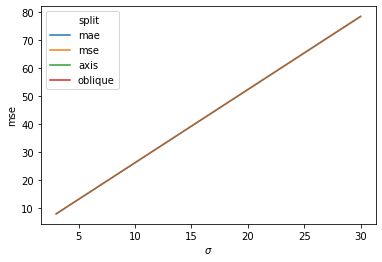

In [12]:
f = sns.lineplot(x="n_dim", y="mse", hue="split", data=df, ci=None, alpha=0.5)
f.set(xlabel=r"$\sigma$", ylabel="mse")

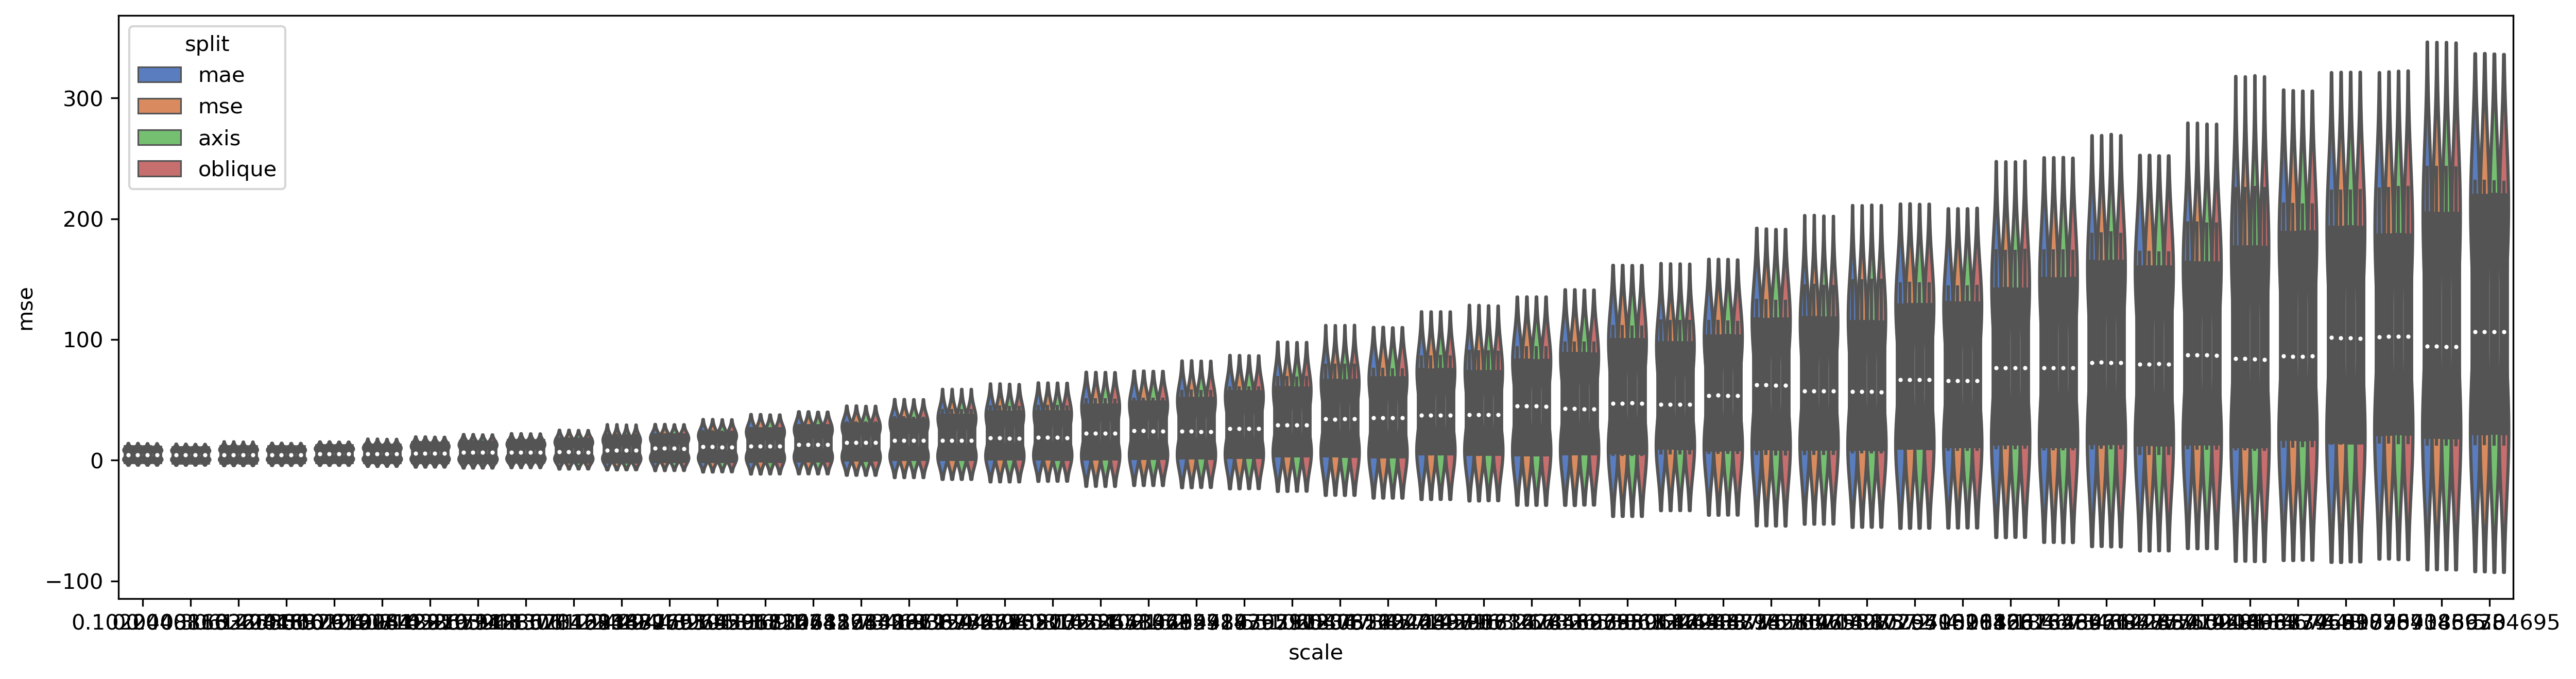

In [13]:
fig, ax = plt.subplots(dpi=300, figsize=(20, 5))
g = sns.violinplot(x="scale", y="mse", hue="split", data=df, palette="muted", ax=ax)

In [14]:
# Test if splitters perform significantly differently with Kruskal-Wallis
for scale in df.scale.unique():

    test = []
    for splitter in ["mae", "mse", "axis", "oblique"]:

        mse = df.query(f"scale=={scale} and split=='{splitter}'").mse.values
        test.append(mse)

    _, pvalue = kruskal(*test)
    print(f"scale: {scale:.2f}, pvalue: {pvalue:.2f}")

scale: 0.00, pvalue: 0.85
scale: 0.10, pvalue: 0.88
scale: 0.20, pvalue: 0.94
scale: 0.31, pvalue: 0.92
scale: 0.41, pvalue: 0.86
scale: 0.51, pvalue: 0.99
scale: 0.61, pvalue: 0.99
scale: 0.71, pvalue: 0.94
scale: 0.82, pvalue: 0.96
scale: 0.92, pvalue: 0.99
scale: 1.02, pvalue: 0.99
scale: 1.12, pvalue: 0.95
scale: 1.22, pvalue: 0.99
scale: 1.33, pvalue: 0.99
scale: 1.43, pvalue: 0.98
scale: 1.53, pvalue: 0.99
scale: 1.63, pvalue: 0.99
scale: 1.73, pvalue: 0.99
scale: 1.84, pvalue: 0.98
scale: 1.94, pvalue: 0.99
scale: 2.04, pvalue: 1.00
scale: 2.14, pvalue: 1.00
scale: 2.24, pvalue: 1.00
scale: 2.35, pvalue: 0.99
scale: 2.45, pvalue: 1.00
scale: 2.55, pvalue: 1.00
scale: 2.65, pvalue: 0.99
scale: 2.76, pvalue: 1.00
scale: 2.86, pvalue: 1.00
scale: 2.96, pvalue: 1.00
scale: 3.06, pvalue: 0.99
scale: 3.16, pvalue: 1.00
scale: 3.27, pvalue: 1.00
scale: 3.37, pvalue: 1.00
scale: 3.47, pvalue: 1.00
scale: 3.57, pvalue: 1.00
scale: 3.67, pvalue: 1.00
scale: 3.78, pvalue: 1.00
scale: 3.88,

### Simulation 3: Nonlinear relationships

Use `mgcpy`'s benchmarking simulation code to generate nonlinear relationships

- Simulations: `cub_sim` and `spiral_sim`
- `n_dim = range(1, 10)`

In [15]:
df = pd.read_csv("results/nonlinear_1.csv", index_col="Unnamed: 0")
df.head()

,sim,n_samples,n_dim,split,mse
0,cub_sim,30,1,mae,261.660386
1,cub_sim,30,1,mae,102.819984
2,cub_sim,30,1,mae,233.244791
3,cub_sim,30,1,mae,649.905212
4,cub_sim,30,1,mae,161.747113


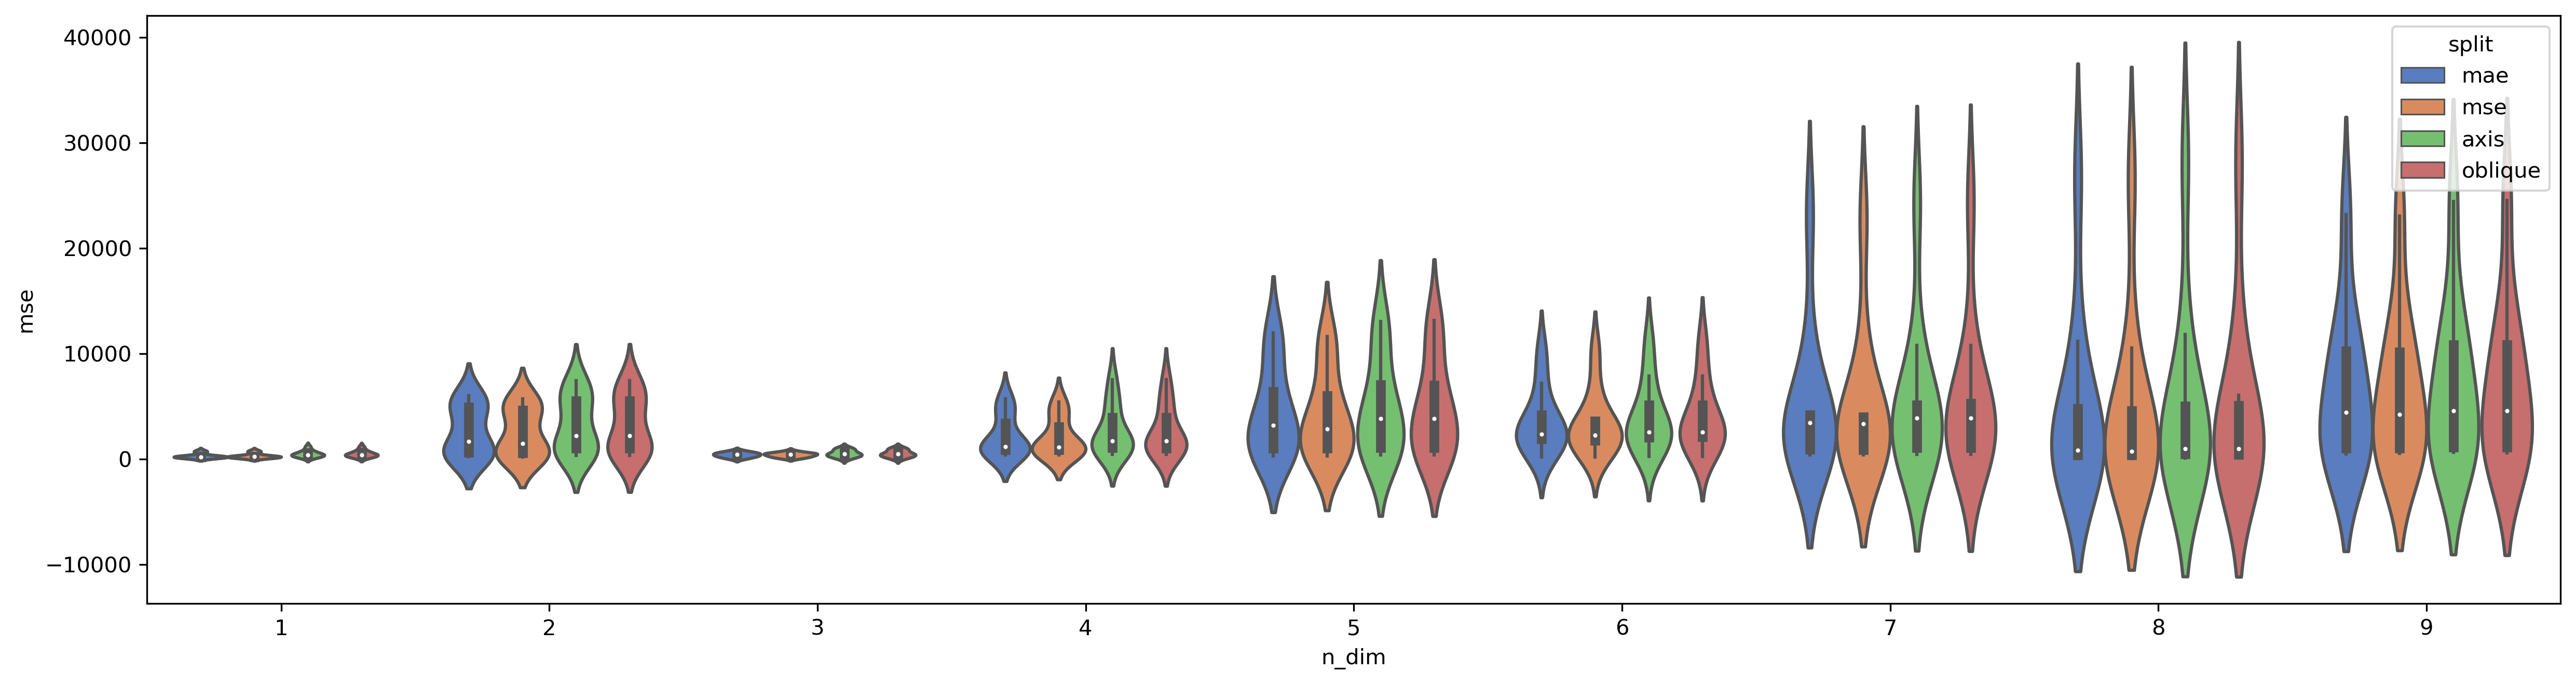

In [16]:
fig, ax = plt.subplots(dpi=300, figsize=(20, 5))
g = sns.violinplot(x="n_dim", y="mse", hue="split", data=df.query("sim=='cub_sim'"), palette="muted", ax=ax)

In [17]:
# Test if splitters perform significantly differently with Kruskal-Wallis
sim = "cub_sim"
for n_dim in df.n_dim.unique():

    test = []
    for splitter in ["mae", "mse", "axis", "oblique"]:

        mse = df.query(f"n_dim=={n_dim} and split=='{splitter}' and sim=='{sim}'").mse.values
        test.append(mse)

    _, pvalue = kruskal(*test)
    print(f"n_dim: {n_dim}, pvalue: {pvalue:.2f}")

n_dim: 1, pvalue: 0.10
n_dim: 2, pvalue: 0.41
n_dim: 3, pvalue: 0.89
n_dim: 4, pvalue: 0.71
n_dim: 5, pvalue: 0.91
n_dim: 6, pvalue: 0.82
n_dim: 7, pvalue: 0.80
n_dim: 8, pvalue: 0.91
n_dim: 9, pvalue: 0.89


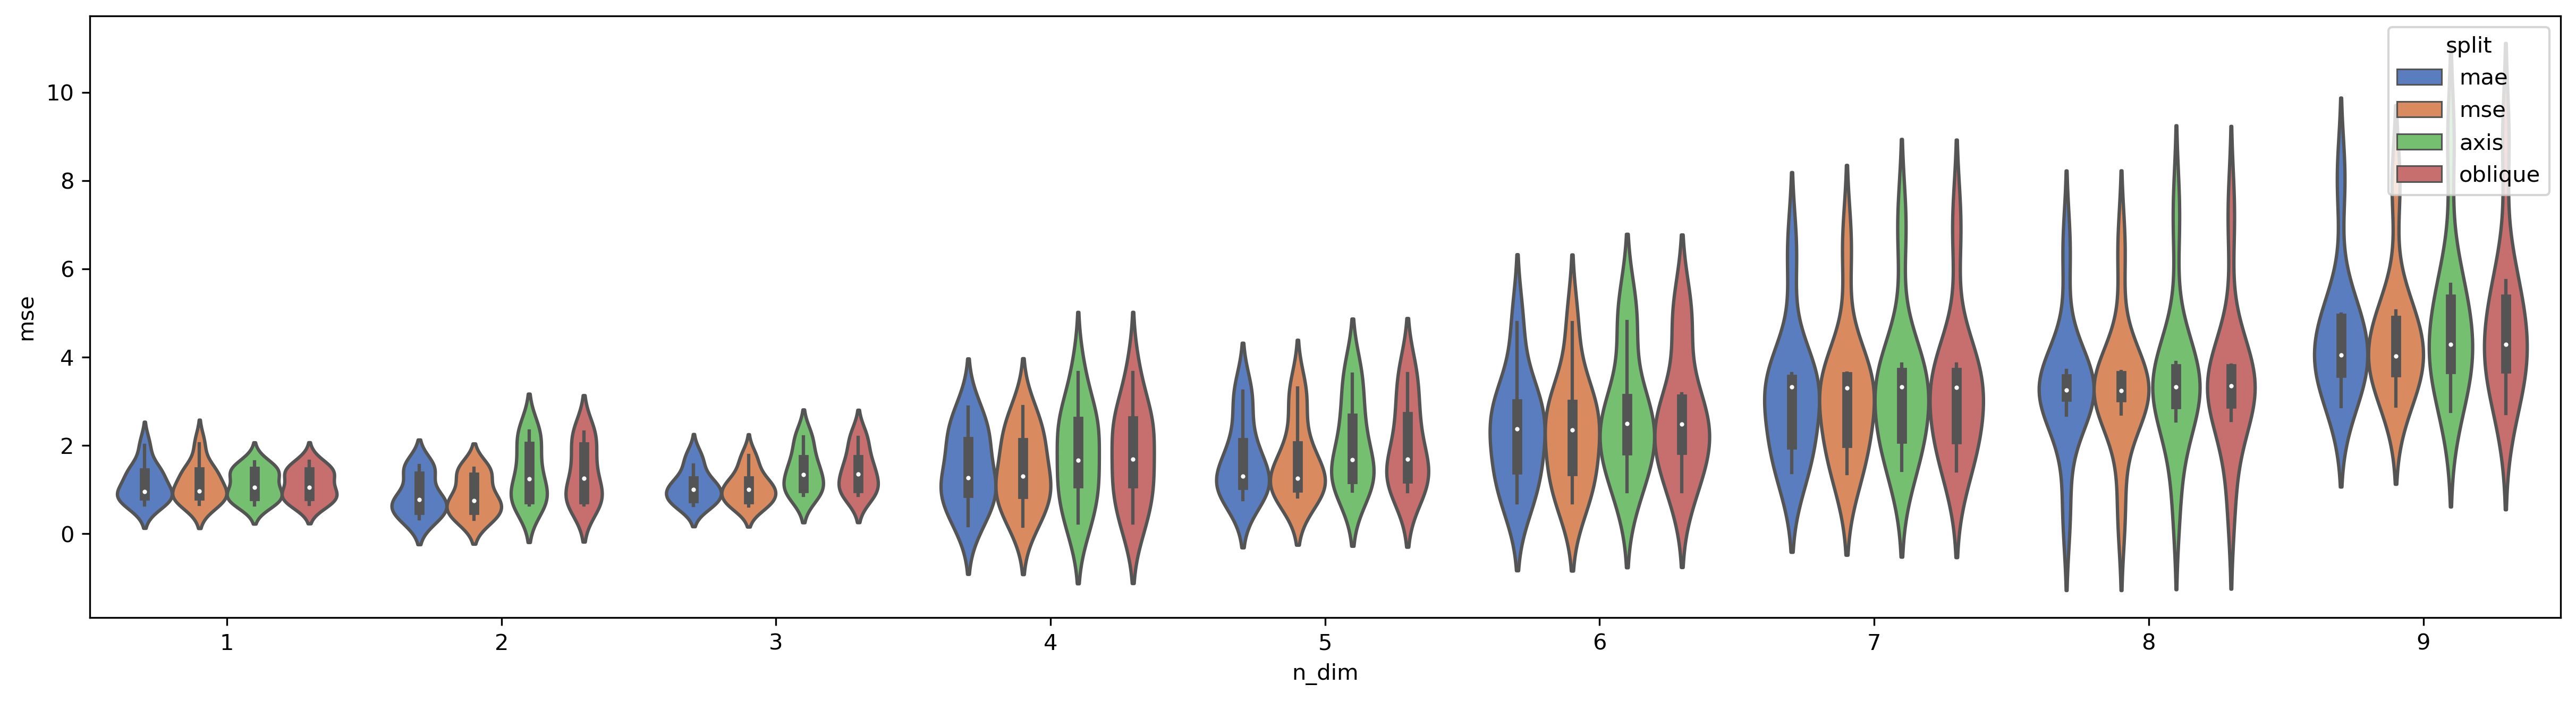

In [18]:
fig, ax = plt.subplots(dpi=300, figsize=(20, 5))
g = sns.violinplot(x="n_dim", y="mse", hue="split", data=df.query("sim=='spiral_sim'"), palette="muted", ax=ax)

In [19]:
# Test if splitters perform significantly differently with Kruskal-Wallis
sim = "spiral_sim"
for n_dim in df.n_dim.unique():

    test = []
    for splitter in ["mae", "mse", "axis", "oblique"]:

        mse = df.query(f"n_dim=={n_dim} and split=='{splitter}' and sim=='{sim}'").mse.values
        test.append(mse)

    _, pvalue = kruskal(*test)
    print(f"n_dim: {n_dim}, pvalue: {pvalue:.2f}")

n_dim: 1, pvalue: 1.00
n_dim: 2, pvalue: 0.06
n_dim: 3, pvalue: 0.09
n_dim: 4, pvalue: 0.82
n_dim: 5, pvalue: 0.53
n_dim: 6, pvalue: 0.89
n_dim: 7, pvalue: 0.88
n_dim: 8, pvalue: 0.94
n_dim: 9, pvalue: 0.90
